In [150]:
"""
import libs and create statistics dataset and helper methods
"""

import pandas as pd
from matplotlib import pyplot as plt
from pandas import DataFrame
from scipy import stats
from scipy.stats._stats_py import SignificanceResult
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

statistics = DataFrame(
    columns=["project", "kendal_v", "kendal_p", "spearman_v", "spearman_p", "y_column", "x_column"]
)


def add_statistics_row(project, kendal_v, kendal_p, spearman_v, spearman_p, y_column, x_column):
    global statistics

    row = DataFrame({
        "project": [project],
        "kendal_v": [kendal_v],
        "kendal_p": [kendal_p],
        "spearman_p": [spearman_p],
        "spearman_v": [spearman_v],
        "y_column": [y_column],
        "x_column": [x_column]
    })
    statistics = pd.concat([statistics, row], ignore_index=True)


def load_masterdata():
    """
    loads the master dataset and converts the timestamp into a pandas interpretable datetime
    :return: the dataframe, a list of all projects from the dataframe
    """

    df = pd.read_csv("data/master-dataset.csv")
    df["total_cumsum"] = df["total"].cumsum()
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    return df, sorted(df["project"].unique())


def regression_and_stats(df: DataFrame, project: str, y_axis_label: str, plot_path: str, x_column_name: str,
                         y_column_names: list[str], show_legend=False, log_scale=False):
    p_df = df[df["project"] == project]
    
    Q1 = df[x_column_name].quantile(0.05)
    Q3 = df[x_column_name].quantile(0.95)
    IQR = Q3 - Q1

    project_df = p_df[(p_df[x_column_name] >= Q1 ) & (p_df[x_column_name] <= Q3)]
    

    plt.xlabel("number of satds in code")
    plt.ylabel(y_axis_label)
    plt.title(project)

    for y_column_name in y_column_names:
        
        
        kendal: SignificanceResult = stats.kendalltau(project_df[y_column_name], project_df[x_column_name])
        spearman: SignificanceResult = stats.spearmanr(project_df[y_column_name], project_df[x_column_name])
        add_statistics_row(project, *kendal, *spearman, y_column_name, x_column_name)

        poly = PolynomialFeatures(degree=3)
        x_poly = poly.fit_transform(project_df[y_column_name].sort_values().to_numpy().reshape(-1, 1))
        y = project_df[x_column_name].to_numpy().reshape(-1, 1)
        model = LinearRegression()
        model.fit(x_poly, y)
        predicted = model.predict(x_poly)
        print("MSE", mean_squared_error(y, predicted))

        if log_scale:
            plt.yscale("log")
        plt.scatter(project_df[y_column_name], project_df[x_column_name], s=3, label=y_column_name)
        plt.plot(project_df[y_column_name].sort_values(), predicted, color="red")

    if show_legend:
        plt.legend()
    plt.savefig(f"{plot_path}/{project}.png")
    plt.show()




# RQ1

/tmp/ipykernel_119246/137177775.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  statistics = pd.concat([statistics, row], ignore_index=True)


MSE 1177.0332674193403


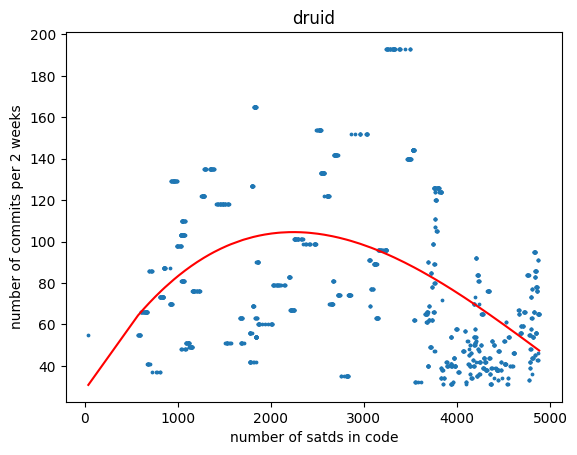

MSE 461.18416426605376


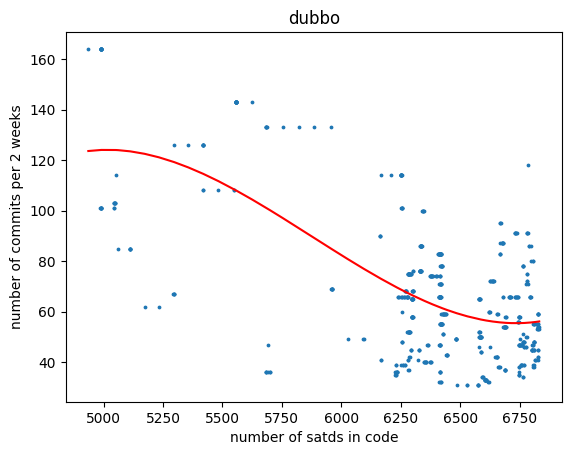

MSE 3738.185561624516


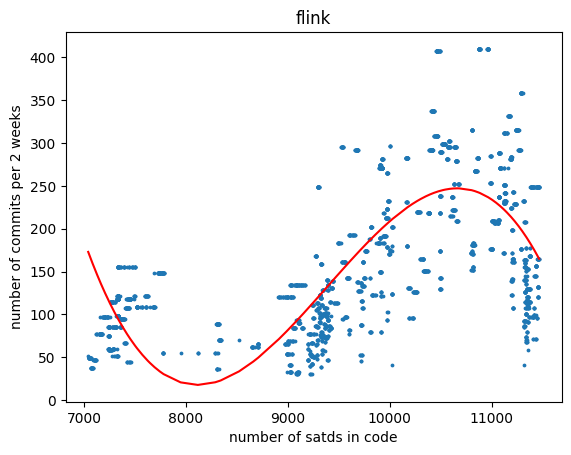

MSE 5191.27358624659


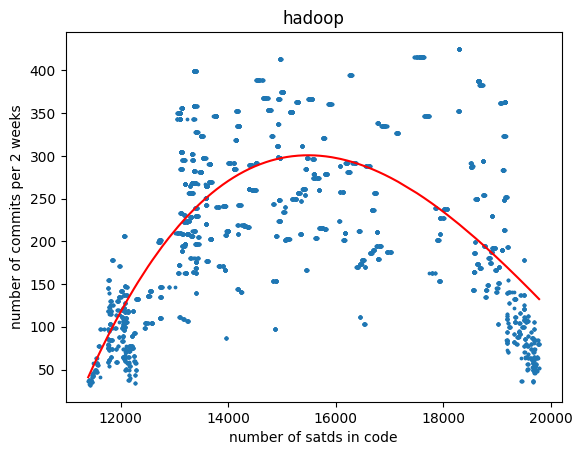

MSE 5629.142125801459


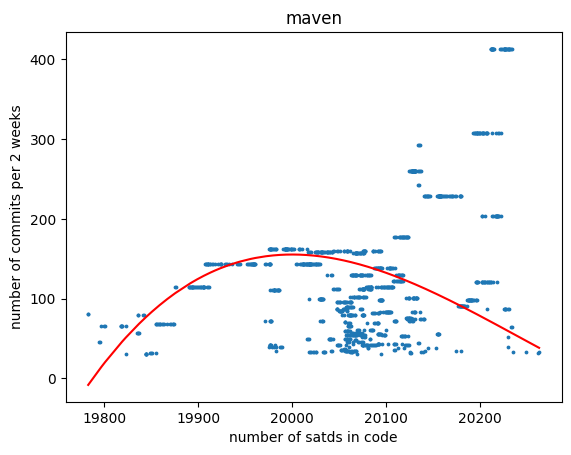

MSE 3923.1248082010975


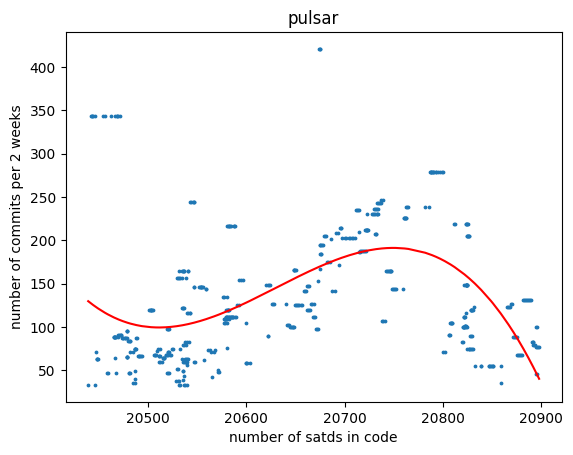

,project,kendal_v,kendal_p,spearman_v,spearman_p,y_column,x_column
0,druid,-0.213480,5.073204e-38,-0.365537,2.520598e-53,total_cumsum,commits_per_14days
1,dubbo,-0.301836,2.329679e-30,-0.429125,5.404352e-31,total_cumsum,commits_per_14days
2,flink,0.412887,2.809978e-294,0.605741,0.000000e+00,total_cumsum,commits_per_14days
3,hadoop,0.111655,3.524863e-40,0.160198,1.337707e-37,total_cumsum,commits_per_14days
4,maven,0.170485,2.379857e-18,0.243654,1.085178e-17,total_cumsum,commits_per_14days
5,pulsar,0.210451,2.257687e-13,0.288772,4.608981e-12,total_cumsum,commits_per_14days


In [151]:
"""
dependence on commit frequency
"""

df, projects = load_masterdata()

for project in projects:
    regression_and_stats(df=df,
                         project=project,
                         y_axis_label="number of commits per 2 weeks",
                         plot_path="plots/rq1/commit_frequency",
                         x_column_name="commits_per_14days",
                         y_column_names=["total_cumsum"])
statistics

MSE 20.747338314393225


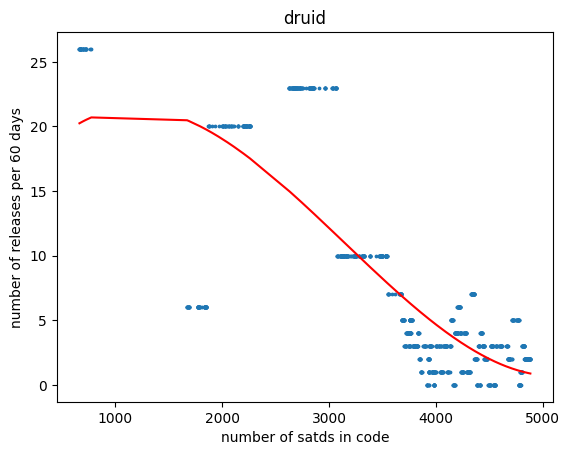

MSE 4.817806877095709


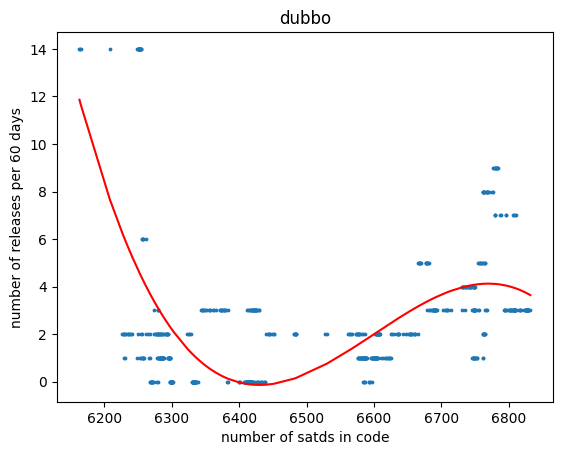

MSE 7.313356395106166


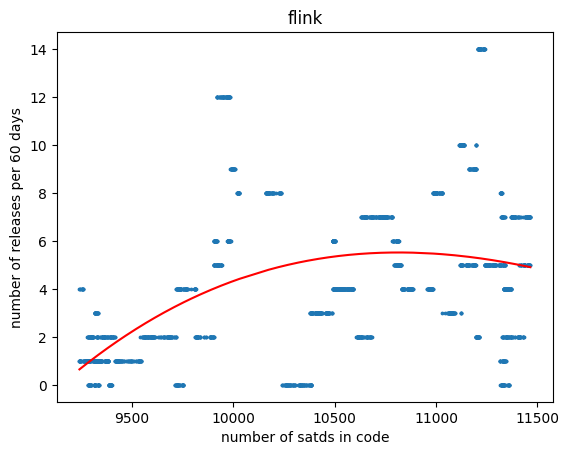

MSE 4.029190508071271


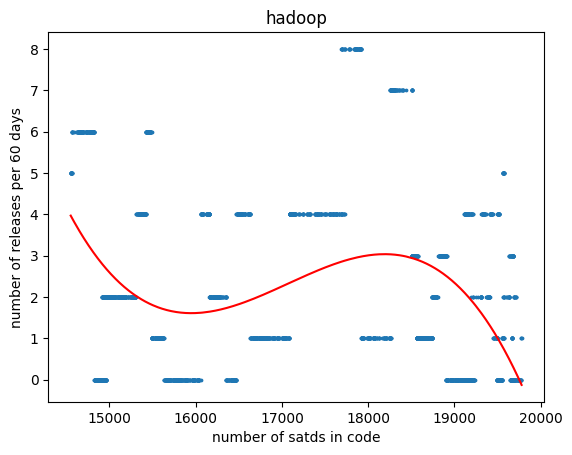

MSE 0.5658718013094725


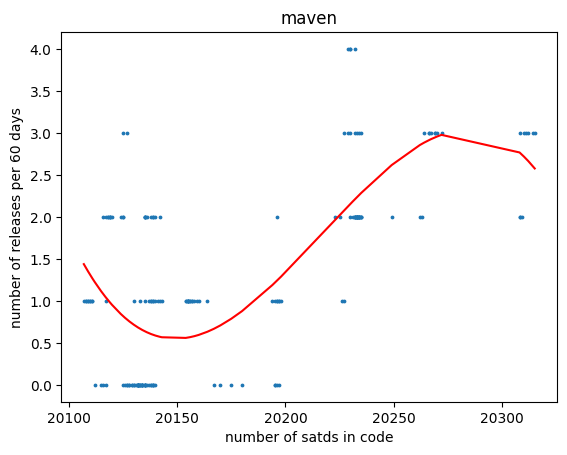

MSE 10.647052969146422


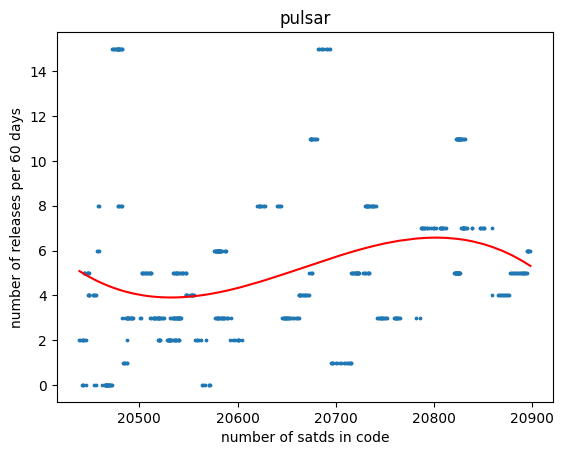

,project,kendal_v,kendal_p,spearman_v,spearman_p,y_column,x_column
0,druid,-0.213480,5.073204e-38,-0.365537,2.520598e-53,total_cumsum,commits_per_14days
1,dubbo,-0.301836,2.329679e-30,-0.429125,5.404352e-31,total_cumsum,commits_per_14days
2,flink,0.412887,2.809978e-294,0.605741,0.000000e+00,total_cumsum,commits_per_14days
3,hadoop,0.111655,3.524863e-40,0.160198,1.337707e-37,total_cumsum,commits_per_14days
4,maven,0.170485,2.379857e-18,0.243654,1.085178e-17,total_cumsum,commits_per_14days
5,pulsar,0.210451,2.257687e-13,0.288772,4.608981e-12,total_cumsum,commits_per_14days
6,druid,-0.585658,4.533708e-206,-0.767735,6.588274e-261,total_cumsum,releases_per_60days
7,dubbo,0.328345,1.089174e-31,0.431291,9.958814e-32,total_cumsum,releases_per_60days
8,flink,0.340876,5.761533e-145,0.468720,1.732051e-151,total_cumsum,releases_per_60days
9,hadoop,-0.100049,6.131489e-16,-0.133634,3.841002e-15,total_cumsum,releases_per_60days


In [152]:
"""
dependence on release speed
"""

df, projects = load_masterdata()
df.dropna(inplace=True)

for project in projects:
    regression_and_stats(df=df,
                         project=project,
                         y_axis_label="number of releases per 60 days",
                         plot_path="plots/rq1/release_frequency",
                         x_column_name="releases_per_60days",
                         y_column_names=["total_cumsum"])
statistics

MSE 795.4579264171788


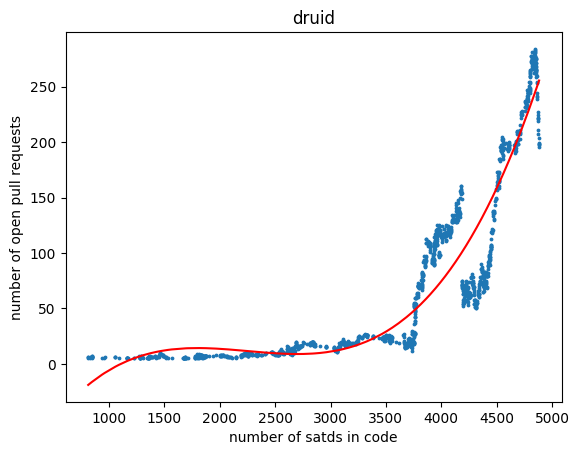

MSE 1075.1745303257042


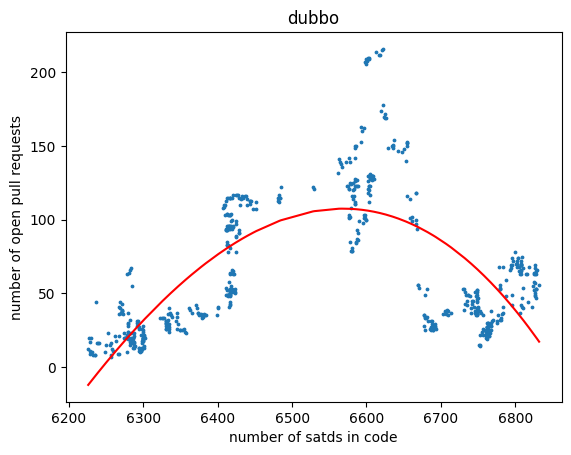

MSE 2162.8934914653287


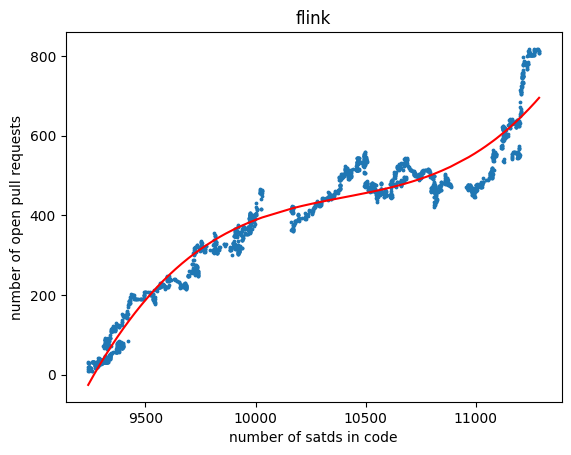

MSE 2054.453932188417


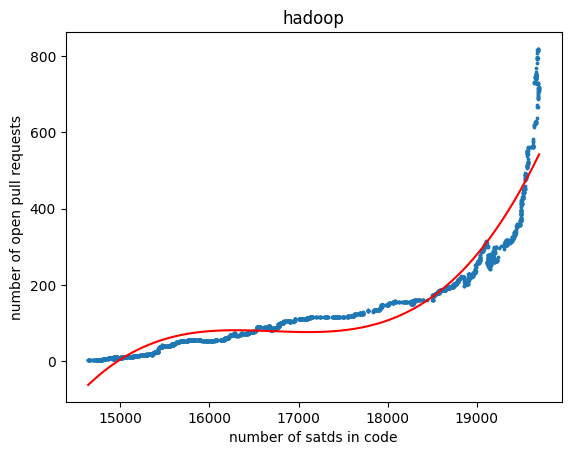

MSE 79.3837278006531


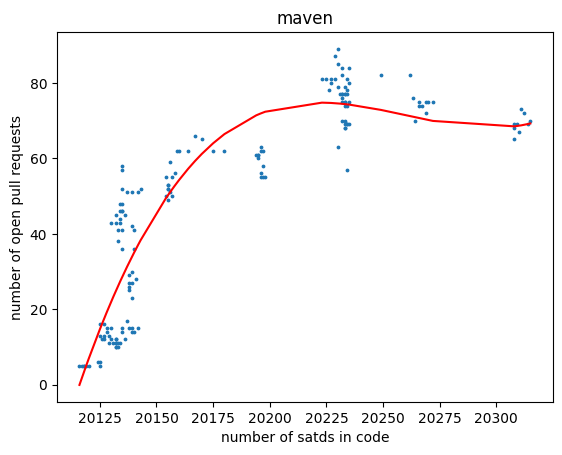

MSE 2971.29881769039


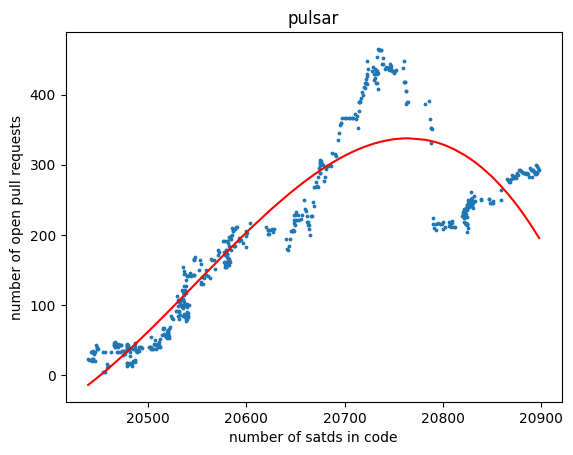

,project,kendal_v,kendal_p,spearman_v,spearman_p,y_column,x_column
0,druid,-0.213480,5.073204e-38,-0.365537,2.520598e-53,total_cumsum,commits_per_14days
1,dubbo,-0.301836,2.329679e-30,-0.429125,5.404352e-31,total_cumsum,commits_per_14days
2,flink,0.412887,2.809978e-294,0.605741,0.000000e+00,total_cumsum,commits_per_14days
3,hadoop,0.111655,3.524863e-40,0.160198,1.337707e-37,total_cumsum,commits_per_14days
4,maven,0.170485,2.379857e-18,0.243654,1.085178e-17,total_cumsum,commits_per_14days
5,pulsar,0.210451,2.257687e-13,0.288772,4.608981e-12,total_cumsum,commits_per_14days
6,druid,-0.585658,4.533708e-206,-0.767735,6.588274e-261,total_cumsum,releases_per_60days
7,dubbo,0.328345,1.089174e-31,0.431291,9.958814e-32,total_cumsum,releases_per_60days
8,flink,0.340876,5.761533e-145,0.468720,1.732051e-151,total_cumsum,releases_per_60days
9,hadoop,-0.100049,6.131489e-16,-0.133634,3.841002e-15,total_cumsum,releases_per_60days


In [153]:
"""
dependence on exact number of open pull requests
"""

df, projects = load_masterdata()
df.dropna(inplace=True)

for project in projects:
    regression_and_stats(df=df,
                         project=project,
                         y_axis_label="number of open pull requests",
                         plot_path="plots/rq1/prs",
                         x_column_name="open_prs_exact",
                         y_column_names=["total_cumsum"])
statistics


In [154]:
# """
# dependence on number of opened pull requests in a kernel of 7 days
# """
# 
# df, projects = load_masterdata()
# df = df.dropna()
# 
# for project in projects:
#     regression_and_stats(df, project, "open_prs_per7", "opened pull requests in a kernel of 7 days", "plots/prs-per7")


# RQ2

In [155]:
"""
prepare masterdataset for rq2
"""

df, projects = load_masterdata()

df["code|design-debt"] = df["code|design-debt"].cumsum()
df["documentation-debt"] = df["documentation-debt"].cumsum()
df["test-debt"] = df["test-debt"].cumsum()
df["requirement-debt"] = df["requirement-debt"].cumsum()

df.dropna(inplace=True)

MSE 812.8282388718698
MSE 736.7620131925679
MSE 824.5113523580059
MSE 805.9591866914234


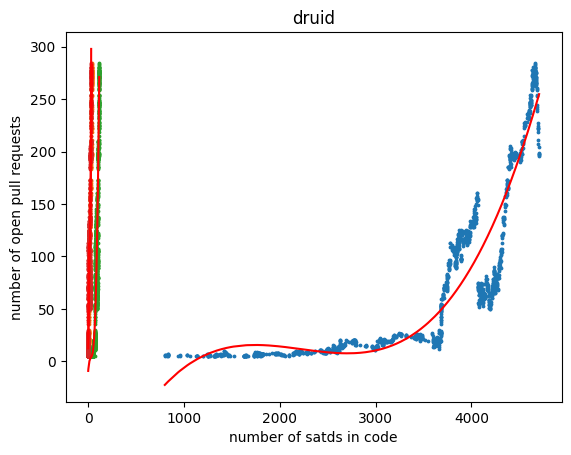

MSE 971.3714577291187
MSE 459.1425852079671
MSE 1142.1450752382948
MSE 2065.780178529581


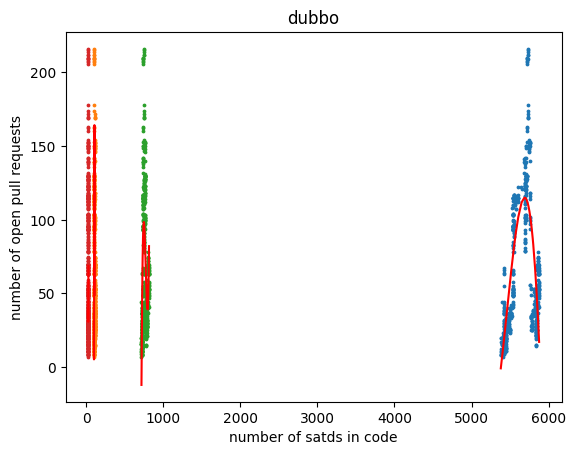

MSE 2315.955395152232
MSE 2131.7834787643797
MSE 2668.1541745701443
MSE 4107.933292061309


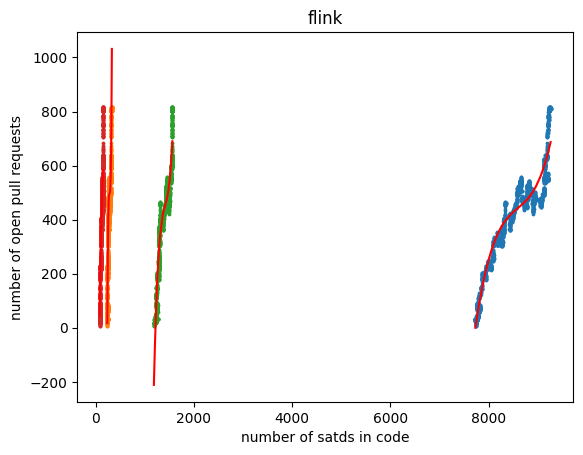

MSE 1852.4764398925324
MSE 998.907135475804
MSE 4586.175429456294
MSE 4511.3610566303105


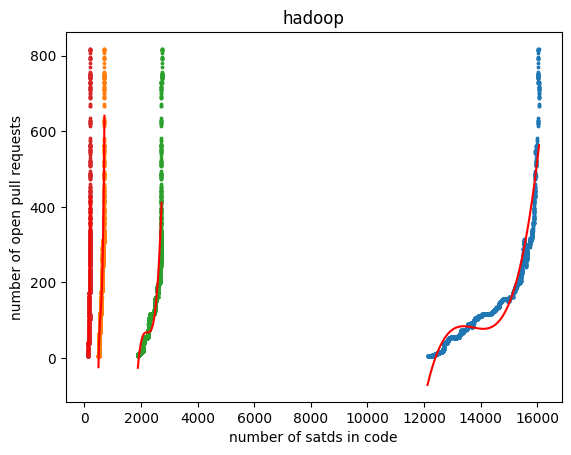

MSE 71.6969363364713
MSE 244.85363085455108
MSE 89.34619343442468
MSE 415.03530511167173


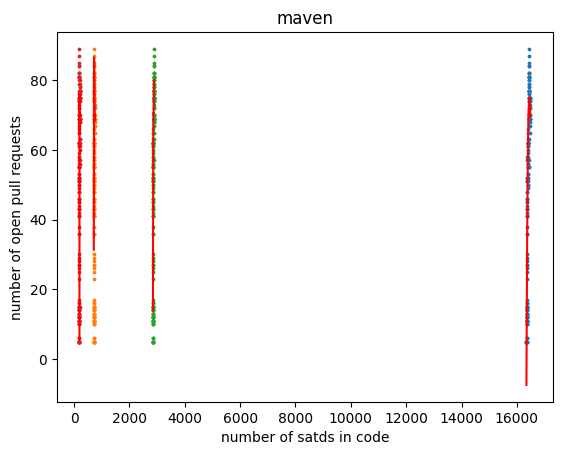

MSE 2908.9012207683963
MSE 3574.1419027610805
MSE 2606.916554584158
MSE 3502.1236546346486


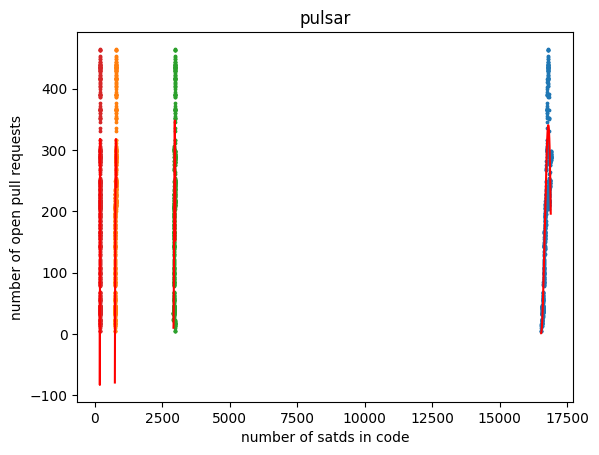

,project,kendal_v,kendal_p,spearman_v,spearman_p,y_column,x_column
0,druid,-0.213480,5.073204e-38,-0.365537,2.520598e-53,total_cumsum,commits_per_14days
1,dubbo,-0.301836,2.329679e-30,-0.429125,5.404352e-31,total_cumsum,commits_per_14days
2,flink,0.412887,2.809978e-294,0.605741,0.000000e+00,total_cumsum,commits_per_14days
3,hadoop,0.111655,3.524863e-40,0.160198,1.337707e-37,total_cumsum,commits_per_14days
4,maven,0.170485,2.379857e-18,0.243654,1.085178e-17,total_cumsum,commits_per_14days
5,pulsar,0.210451,2.257687e-13,0.288772,4.608981e-12,total_cumsum,commits_per_14days
6,druid,-0.585658,4.533708e-206,-0.767735,6.588274e-261,total_cumsum,releases_per_60days
7,dubbo,0.328345,1.089174e-31,0.431291,9.958814e-32,total_cumsum,releases_per_60days
8,flink,0.340876,5.761533e-145,0.468720,1.732051e-151,total_cumsum,releases_per_60days
9,hadoop,-0.100049,6.131489e-16,-0.133634,3.841002e-15,total_cumsum,releases_per_60days


In [156]:
"""
dependence of exact number of open pull requests on every type of satd
"""

for project in projects:
    regression_and_stats(df=df,
                         project=project,
                         y_axis_label="number of open pull requests",
                         plot_path="plots/rq2/prs",
                         x_column_name="open_prs_exact",
                         y_column_names=["code|design-debt", "test-debt", "requirement-debt", "documentation-debt"])
statistics

MSE 1198.7887006818535
MSE 1158.0762082125377
MSE 1208.48905969824
MSE 1079.2835557619228


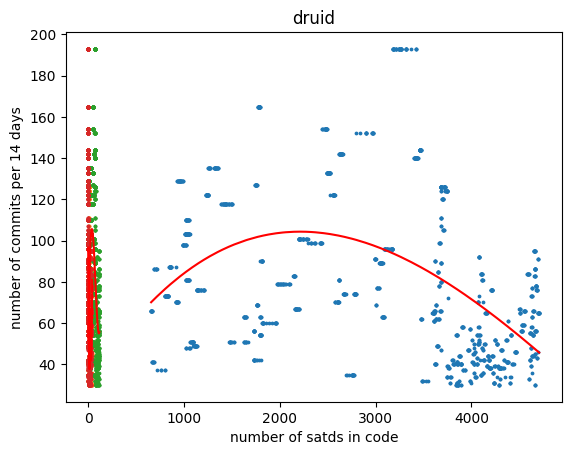

MSE 332.1419156696106
MSE 337.198084663021
MSE 330.40727734223316
MSE 289.95594857020916


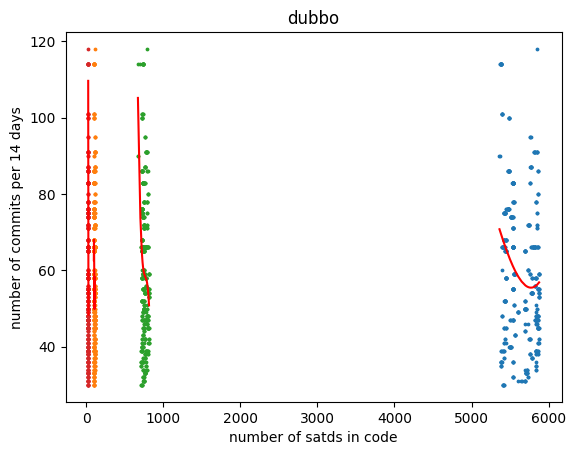

MSE 4754.279995253081
MSE 4691.305497935782
MSE 4836.904766607381
MSE 5588.477185719457


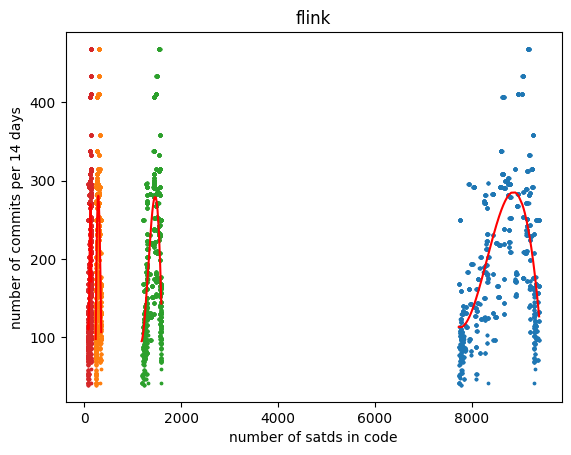

MSE 5958.0089572045
MSE 6019.7296176184045
MSE 6511.550254600396
MSE 6911.735171511901


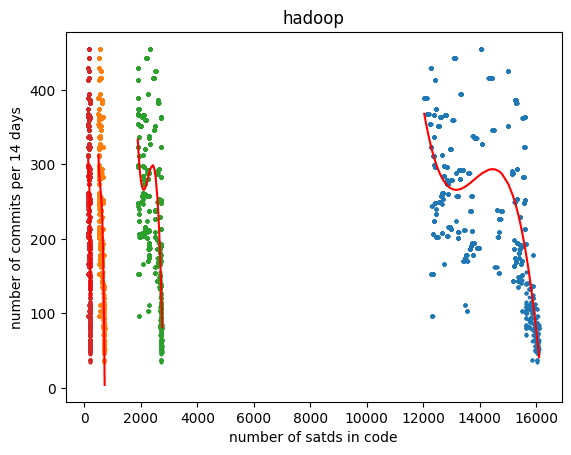

MSE 5105.871047833096
MSE 5686.1761363638025
MSE 5729.954518706289
MSE 6009.758974358973


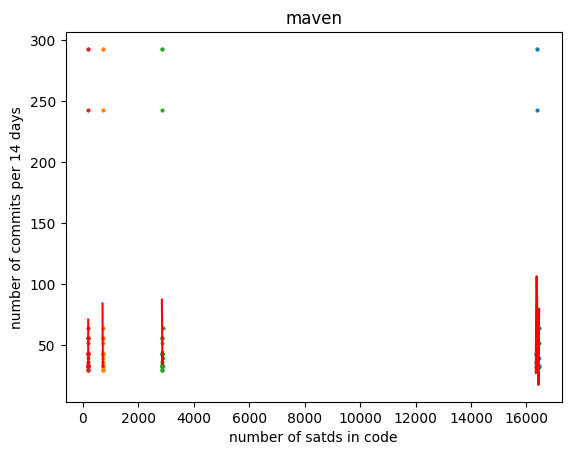

MSE 4019.5619195042527
MSE 4099.019734624542
MSE 4004.473642041134
MSE 4105.594091786766


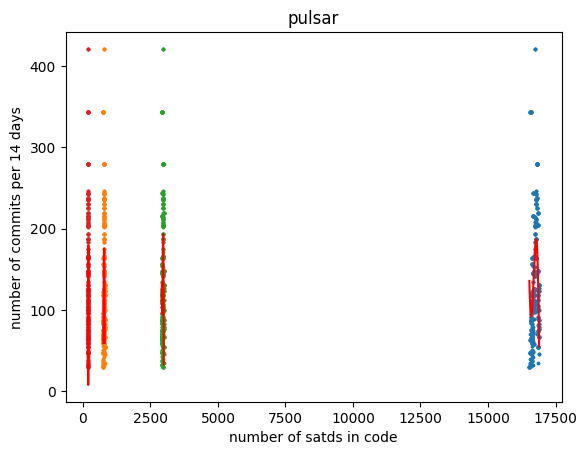

,project,kendal_v,kendal_p,spearman_v,spearman_p,y_column,x_column
0,druid,-0.213480,5.073204e-38,-0.365537,2.520598e-53,total_cumsum,commits_per_14days
1,dubbo,-0.301836,2.329679e-30,-0.429125,5.404352e-31,total_cumsum,commits_per_14days
2,flink,0.412887,2.809978e-294,0.605741,0.000000e+00,total_cumsum,commits_per_14days
3,hadoop,0.111655,3.524863e-40,0.160198,1.337707e-37,total_cumsum,commits_per_14days
4,maven,0.170485,2.379857e-18,0.243654,1.085178e-17,total_cumsum,commits_per_14days
...,...,...,...,...,...,...,...
61,maven,-0.017878,8.960709e-01,-0.020917,8.980624e-01,documentation-debt,commits_per_14days
62,pulsar,0.229017,1.108194e-15,0.315316,2.400434e-14,code|design-debt,commits_per_14days
63,pulsar,0.236160,6.265202e-16,0.317385,1.592086e-14,test-debt,commits_per_14days
64,pulsar,0.125226,1.495876e-05,0.151995,3.141659e-04,requirement-debt,commits_per_14days


In [157]:
"""
dependence of commit frequency on every type of satd
"""

for project in projects:
    regression_and_stats(df=df,
                         project=project,
                         y_axis_label="number of commits per 14 days",
                         plot_path="plots/rq2/commit_frequency",
                         x_column_name="commits_per_14days",
                         y_column_names=["code|design-debt", "test-debt", "requirement-debt", "documentation-debt"])
statistics

MSE 20.71583693500671
MSE 21.396436340251867
MSE 23.050625357659662
MSE 32.533468648755836


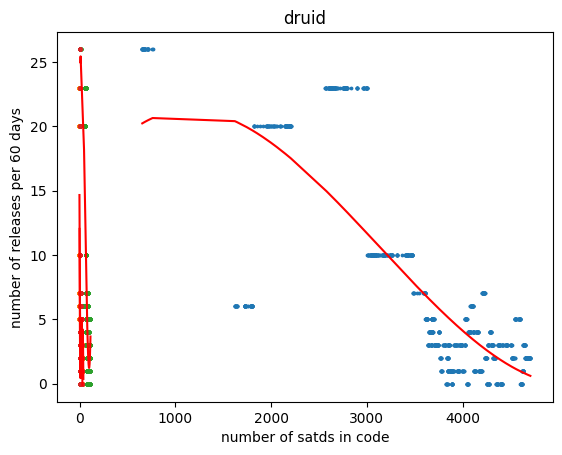

MSE 5.028862150762537
MSE 5.841996912105517
MSE 5.734669695033594
MSE 4.282016431752856


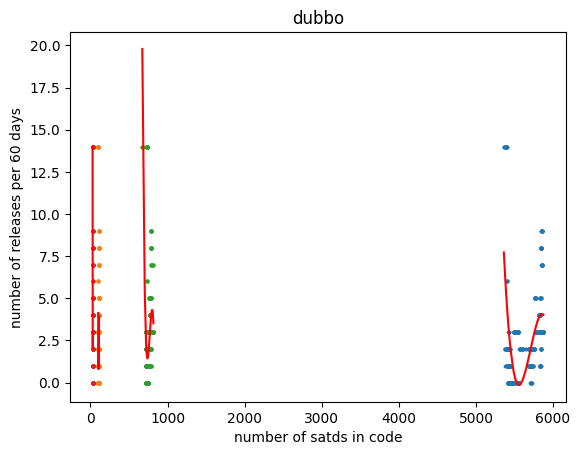

MSE 7.225710178010239
MSE 6.7008580022410085
MSE 7.875497244262263
MSE 7.2963503114681965


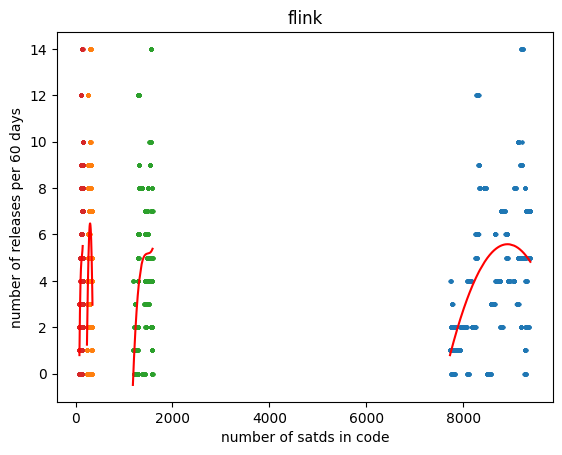

MSE 4.031748090905261
MSE 4.428079337670809
MSE 3.961557618351933
MSE 4.145056003296835


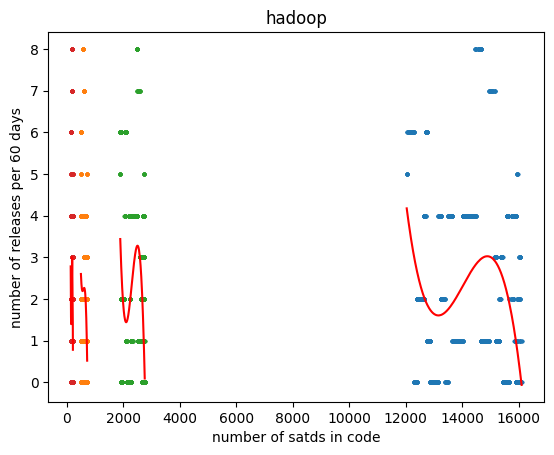

MSE 0.5993679921205306
MSE 0.78588627603259
MSE 0.5568202142037554
MSE 0.8156879794934206


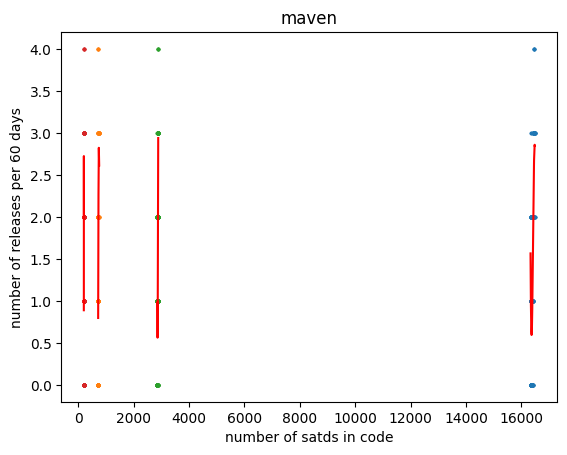

MSE 10.718412954496312
MSE 10.475595441794876
MSE 10.666416713747328
MSE 10.44234929694871


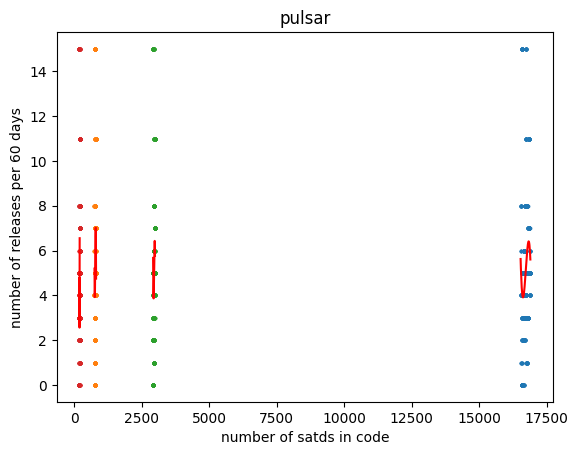

,project,kendal_v,kendal_p,spearman_v,spearman_p,y_column,x_column
0,druid,-0.213480,5.073204e-38,-0.365537,2.520598e-53,total_cumsum,commits_per_14days
1,dubbo,-0.301836,2.329679e-30,-0.429125,5.404352e-31,total_cumsum,commits_per_14days
2,flink,0.412887,2.809978e-294,0.605741,0.000000e+00,total_cumsum,commits_per_14days
3,hadoop,0.111655,3.524863e-40,0.160198,1.337707e-37,total_cumsum,commits_per_14days
4,maven,0.170485,2.379857e-18,0.243654,1.085178e-17,total_cumsum,commits_per_14days
...,...,...,...,...,...,...,...
85,maven,0.000240,9.971416e-01,-0.008390,9.109915e-01,documentation-debt,releases_per_60days
86,pulsar,0.270802,4.354471e-20,0.374336,1.150351e-20,code|design-debt,releases_per_60days
87,pulsar,0.275112,6.837219e-20,0.370955,2.695365e-20,test-debt,releases_per_60days
88,pulsar,0.270122,1.453436e-19,0.386182,5.373532e-22,requirement-debt,releases_per_60days


In [158]:
"""
dependence of release frequency on every type of satd
"""

for project in projects:
    regression_and_stats(df=df,
                         project=project,
                         y_axis_label="number of releases per 60 days",
                         plot_path="plots/rq2/release_frequency",
                         x_column_name="releases_per_60days",
                         y_column_names=["code|design-debt", "test-debt", "requirement-debt", "documentation-debt"])
statistics

In [159]:
"""
Execute all cells sequentially before running this cell
It stores the kendal and spearman values all together in a statistics.csv file
"""

statistics.to_csv("data/statistics.csv")